In [20]:
import pandas as pd
import datetime as dt
from datetime import datetime,timedelta

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.plot import plot_plotly

In [2]:
sales_data = pd.read_csv('sales_data.csv',parse_dates=['date'])

In [3]:
sales_data

,date,sales
0,2016-06-01,12
1,2016-06-02,22
2,2016-06-03,19
3,2016-06-04,20
4,2016-06-05,5
...,...,...
1457,2020-05-28,13
1458,2020-05-29,15
1459,2020-05-30,27
1460,2020-05-31,4


In [4]:
sales_data.isna().sum()

date     0
sales    0
dtype: int64

In [5]:
sales_data.duplicated().sum()

0

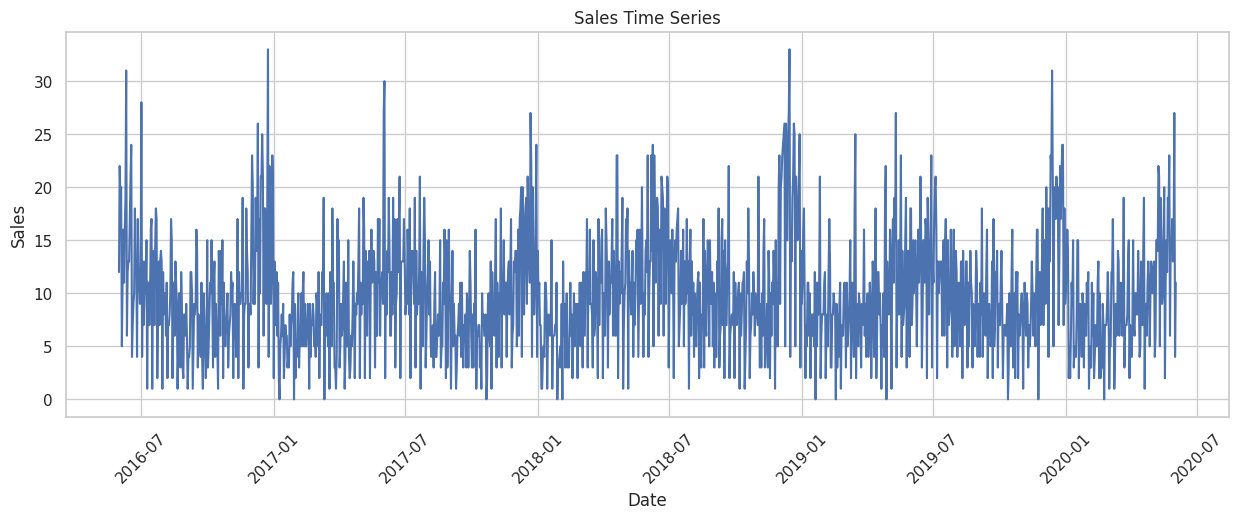

In [6]:
# Time series plot
sns.set(style="whitegrid")
plt.figure(figsize=(15,5))

sns.lineplot(data=sales_data, x='date', y='sales')

plt.title('Sales Time Series')
plt.xlabel('Date')
plt.ylabel('Sales')

plt.xticks(rotation=45)
plt.show()

In [7]:
# Get the time series trend

import statsmodels.api as sm

decomposition = sm.tsa.seasonal_decompose(sales_data.set_index('date')['sales'], model='additive')

trend=decomposition.trend

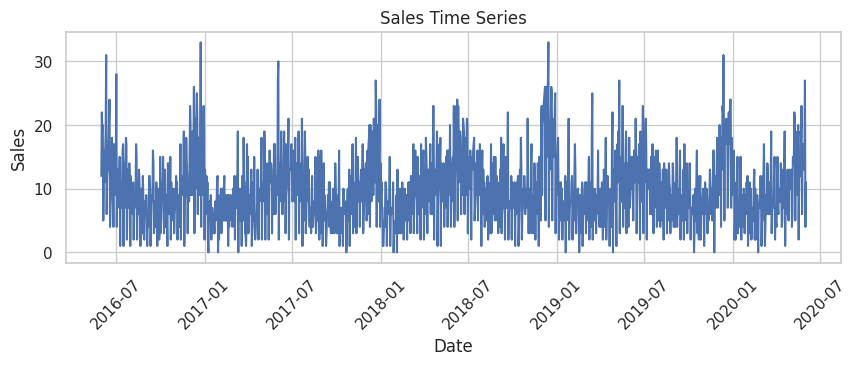

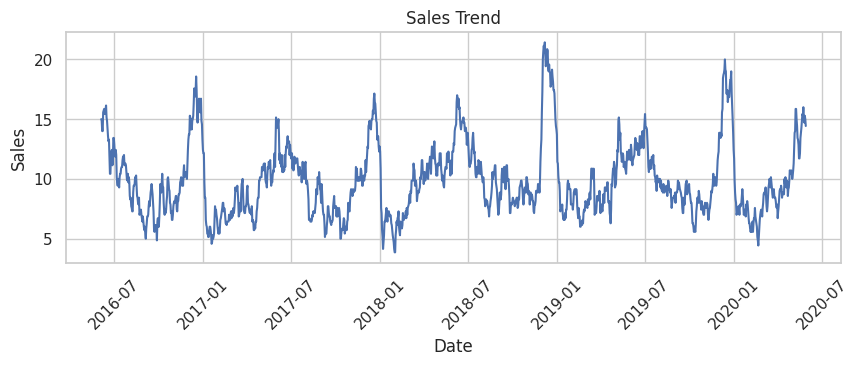

In [8]:
# Time series + Trend plot

plt.figure(figsize=(10,3))

sns.lineplot(data=sales_data, x='date', y='sales')

plt.title('Sales Time Series')
plt.xlabel('Date')
plt.ylabel('Sales')

plt.xticks(rotation=45)
plt.show()

print('')

plt.figure(figsize=(10,3))

sns.lineplot(data=trend)

plt.title('Sales Trend')
plt.xlabel('Date')
plt.ylabel('Sales')

plt.xticks(rotation=45)
plt.show()

##Prediction model using Prophet

In [9]:
# Define date range
days_to_forecast = 720 # We define the number of days we want to predict counting from the last date
start_date = sales_data.date.iloc[-1]
end_date = start_date + timedelta(days=days_to_forecast)
date_range = pd.date_range(start=start_date, end=end_date, freq='D')

# Dataframe to use for future values
future = pd.DataFrame({'ds': date_range, 'y': np.nan})

In [10]:
# We use Prophet model to predict the data
m = Prophet()

train=sales_data.rename(columns={'date':'ds', 'sales':'y'})

# Train the model
m.fit(train)

# Future predict
forecast = m.predict(future)

# We also predict the train data
forecast_train = m.predict(train)

# In the final forecast we merge both of them
forecast_final = pd.concat([forecast_train, forecast])

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp14itjfn/itrp3cen.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpp14itjfn/4obpfxr4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=33306', 'data', 'file=/tmp/tmpp14itjfn/itrp3cen.json', 'init=/tmp/tmpp14itjfn/4obpfxr4.json', 'output', 'file=/tmp/tmpp14itjfn/prophet_modeljczlwk1h/prophet_model-20231128104915.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:49:15 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:49:15 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


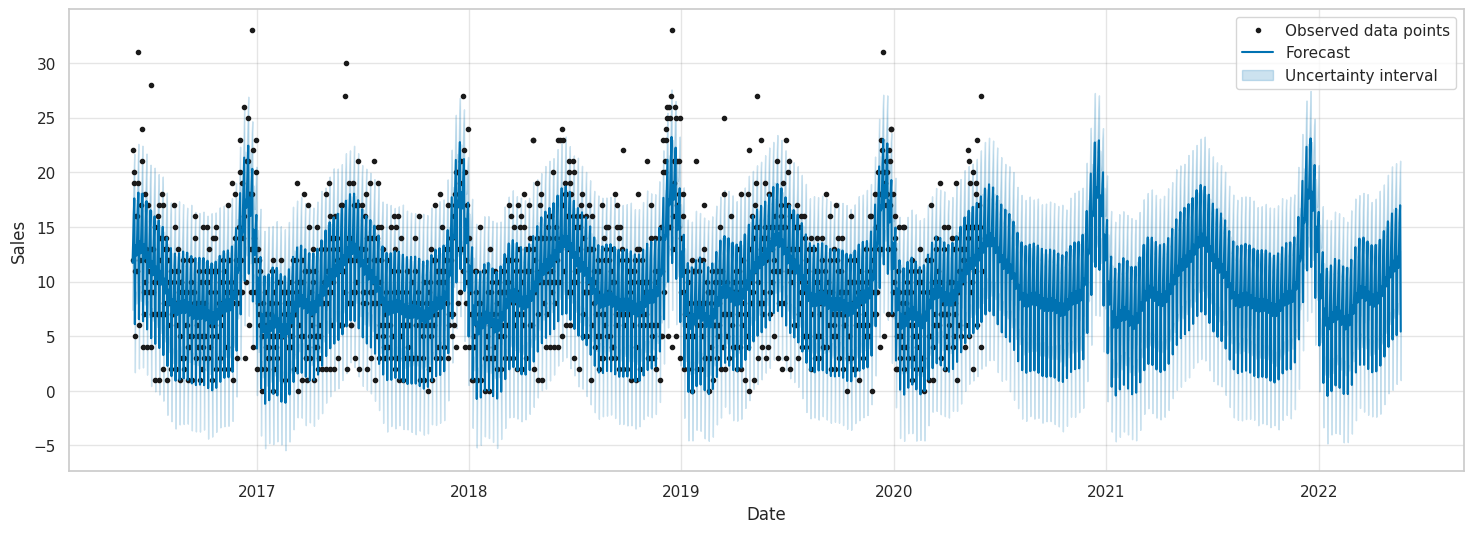

In [11]:
# Plot the predictions

fig, ax = plt.subplots(figsize=(18, 6))
m.plot(forecast_final, ax=ax)
plt.legend(bbox_to_anchor=(1, 1))
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

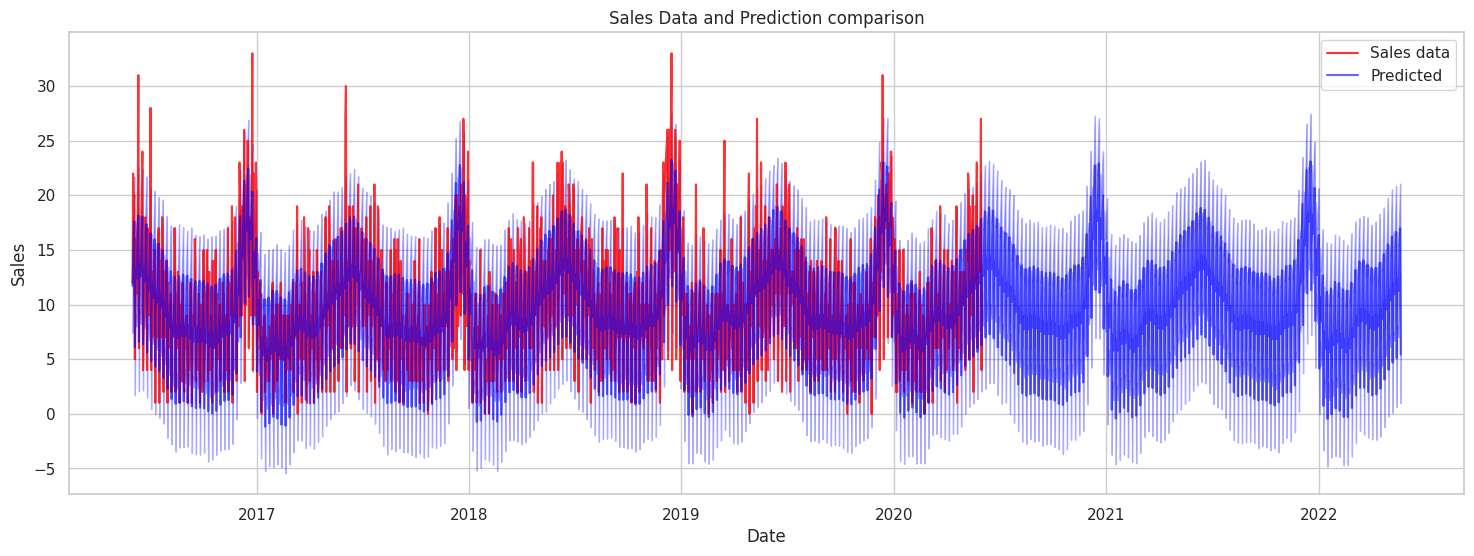

In [19]:
# Here we compare temporal series prediction versus the original one

plt.figure(figsize = (18,6))

plt.plot(sales_data.date, sales_data.sales, color='red', alpha = 0.8, label = 'Sales data')

plt.plot(forecast_final.ds, forecast_final.yhat, alpha = 0.6,
         label = 'Predicted', color = 'blue')
plt.fill_between(forecast_final.ds, forecast_final.yhat_lower, forecast_final.yhat_upper,
                 alpha = 0.3, color = 'blue' )

plt.title('Sales Data and Prediction comparison')
plt.ylabel('Sales')
plt.xlabel('Date')
plt.legend()
plt.show()

In [13]:
# Now we merge the original dataset with the future prediction

merged_df = pd.merge(sales_data, forecast_final[forecast_final.ds>sales_data.date.iloc[-1]].rename(columns={'ds':'date', 'yhat':'sales'}), on='date', how='outer')
merged_df = merged_df.fillna(0)
merged_df['sales'] = merged_df['sales_x'] + merged_df['sales_y']
merged_df = merged_df[['date', 'sales']]

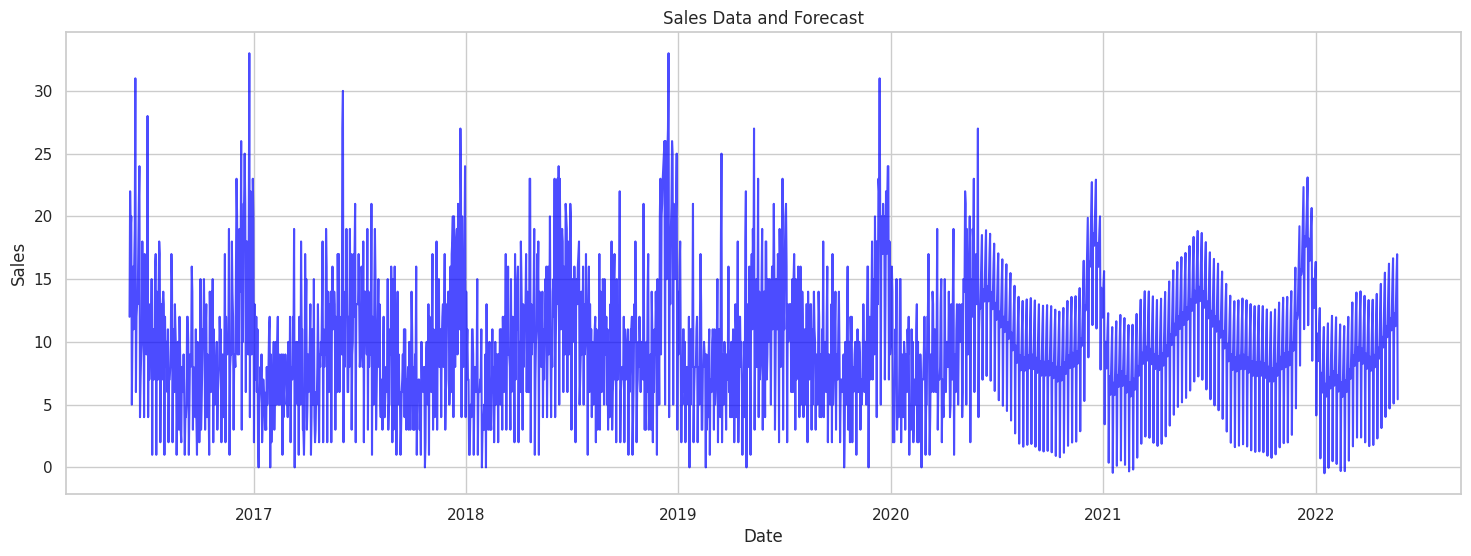

In [16]:
# Plot of original + future prediction
plt.figure(figsize = (18,6))
plt.plot(merged_df.date, merged_df.sales, color='blue', alpha=0.7, label = 'sales_data')
plt.title('Sales Data and Forecast')
plt.ylabel('Sales')
plt.xlabel('Date')
plt.show()